[INFO] Saved raw means → E:\MLME\Final\experiment_column_means.csv


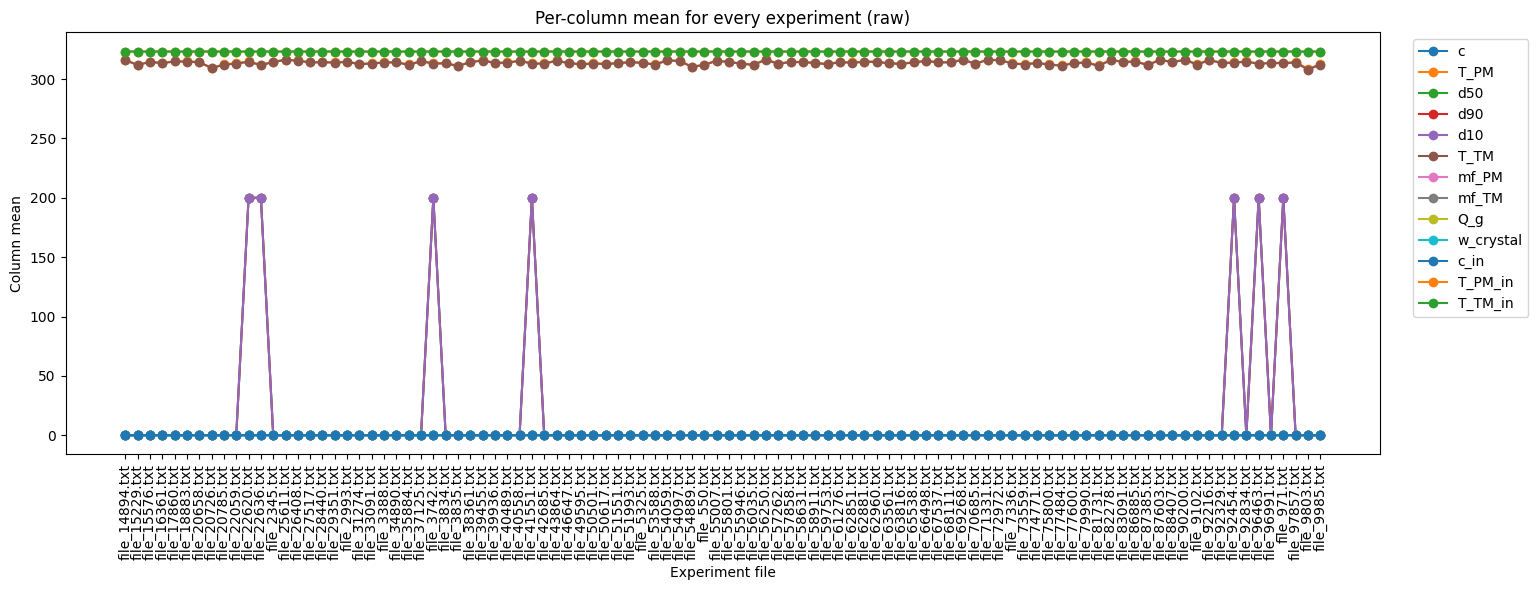

[INFO] Filtered 7 outlier run(s) → E:\MLME\Final\removed_experiments.csv
[INFO] Clean means table → E:\MLME\Final\experiment_column_means_filtered.csv


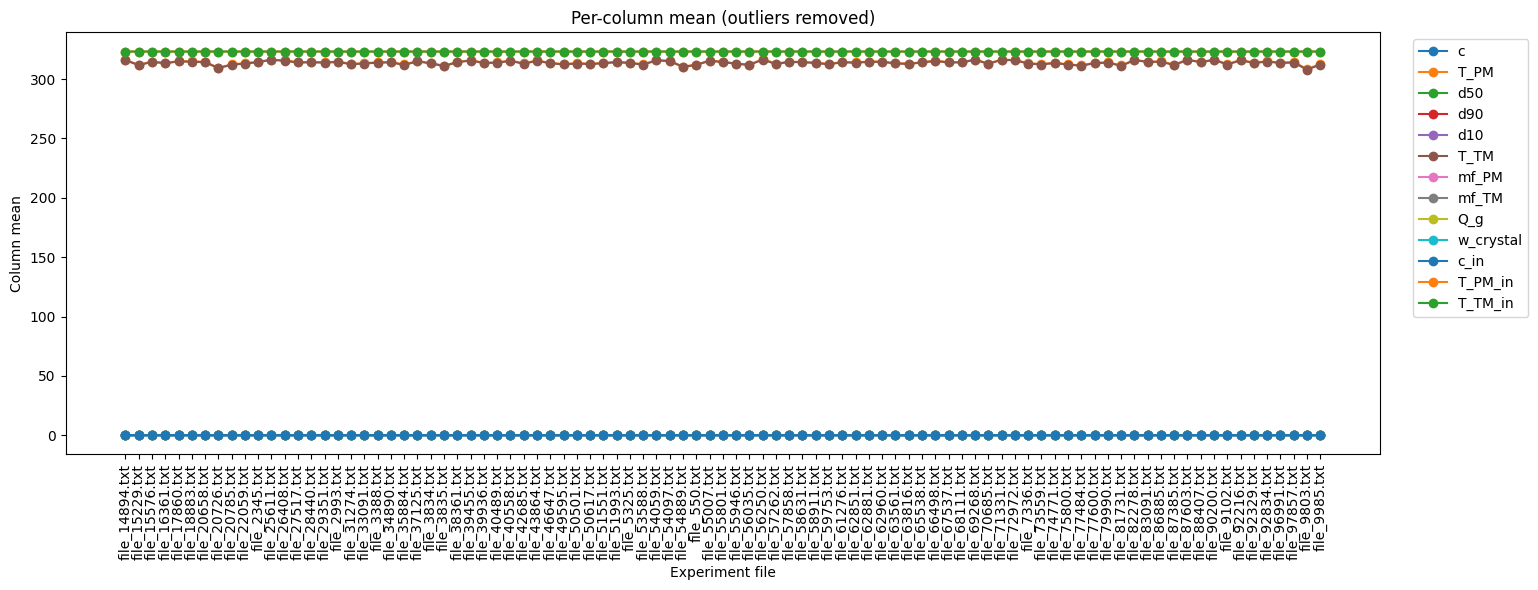

c:\Users\tej31\anaconda3\envs\PAS_2525\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\tej31\anaconda3\envs\PAS_2525\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\tej31\anaconda3\envs\PAS_2525\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\tej31\anaconda3\envs\PAS_2525\lib\site-packages\sklearn\cluster\_kmeans.py:1419: User

[INFO] K-means finished → k = 2 (silhouette = 0.302)
[INFO] Assignment table → E:\MLME\Final\cluster_assignments.csv


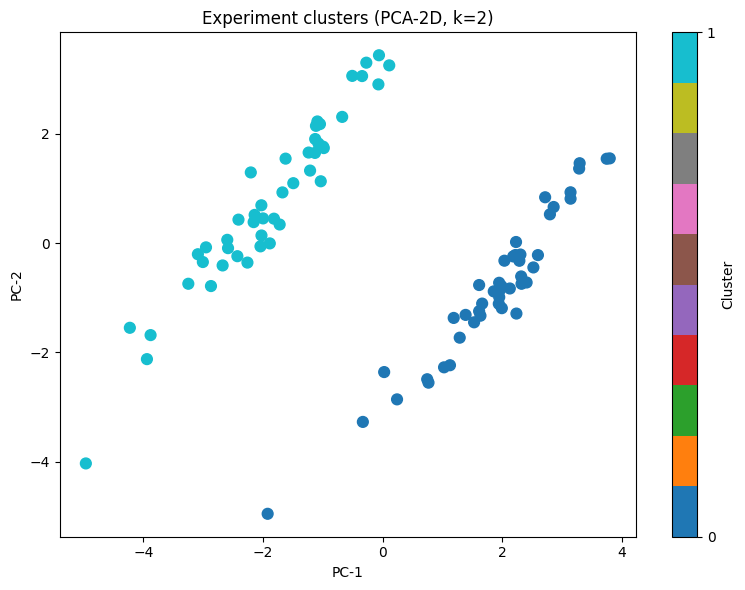

[INFO] PCA image saved → E:\MLME\Final\pca_clusters.png


In [2]:
"""
Full pipeline:
1.  Read all .txt experiments → per-column means
2.  Flag & remove outliers (d10/d50/d90, 1.5×IQR)
3.  Plot raw & filtered means
4.  K-means cluster clean experiments (auto-k via silhouette)
5.  Save:
      • experiment_column_means.csv
      • removed_experiments.csv
      • experiment_column_means_filtered.csv
      • cluster_assignments.csv
      • cluster_<k>.csv  (one per cluster)
      • pca_clusters.png
Requires: pandas, numpy, matplotlib, scikit-learn
"""

from __future__ import annotations
import os, sys, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# ═════════════════════════════════════════════════════════════
# 0. USER SETTINGS –--- edit these two paths only!
# ═════════════════════════════════════════════════════════════
DATA_DIR_IN  = r"E:\MLME\release\data"   # folder with .txt files
DATA_DIR_OUT = r"E:\MLME\Final"          # where results will be written
os.makedirs(DATA_DIR_OUT, exist_ok=True)

# ═════════════════════════════════════════════════════════════
# 1. GATHER EXPERIMENT FILES
# ═════════════════════════════════════════════════════════════
txt_files = [
    os.path.join(root, fn)
    for root, _, files in os.walk(DATA_DIR_IN)
    for fn in files
    if fn.lower().endswith(".txt")
]
if not txt_files:
    sys.exit(f"[ERROR] No .txt files found under {DATA_DIR_IN}")

# ═════════════════════════════════════════════════════════════
# 2. BUILD TABLE OF COLUMN MEANS
# ═════════════════════════════════════════════════════════════
rows: list[pd.Series] = []
for fp in txt_files:
    try:
        df = pd.read_csv(fp, sep="\t")
    except Exception:
        df = pd.read_csv(fp, delim_whitespace=True)

    num_df = df.select_dtypes(include=[np.number])
    if num_df.empty:
        warnings.warn(f"{os.path.basename(fp)} → skipped (no numeric cols)")
        continue

    s = num_df.mean()
    s.name = os.path.basename(fp)          # row label = file name
    rows.append(s)

means_df = pd.DataFrame(rows).sort_index()
raw_csv = os.path.join(DATA_DIR_OUT, "experiment_column_means.csv")
means_df.to_csv(raw_csv, index_label="experiment")
print(f"[INFO] Saved raw means → {raw_csv}")

# ═════════════════════════════════════════════════════════════
# 3. RAW PLOT
# ═════════════════════════════════════════════════════════════
plt.figure(figsize=(14, 6))
for col in means_df.columns:
    plt.plot(means_df.index, means_df[col], marker="o", label=col)
plt.title("Per-column mean for every experiment (raw)")
plt.xlabel("Experiment file"); plt.ylabel("Column mean")
plt.xticks(rotation=90); plt.tight_layout()
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.show()

# ═════════════════════════════════════════════════════════════
# 4. OUTLIER FILTER (d10 / d50 / d90, 1.5×IQR)
# ═════════════════════════════════════════════════════════════
def iqr_mask(series: pd.Series) -> pd.Series:
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    return (series < q1 - 1.5 * iqr) | (series > q3 + 1.5 * iqr)

cols_check = [c for c in ("d10", "d50", "d90") if c in means_df.columns]
mask_outlier = pd.Series(False, index=means_df.index)
for c in cols_check:
    mask_outlier |= iqr_mask(means_df[c])

removed_df = means_df[mask_outlier]
kept_df    = means_df[~mask_outlier]

removed_csv  = os.path.join(DATA_DIR_OUT, "removed_experiments.csv")
kept_csv     = os.path.join(DATA_DIR_OUT, "experiment_column_means_filtered.csv")
removed_df.index.to_series().to_csv(removed_csv, index=False, header=False)
kept_df.to_csv(kept_csv, index_label="experiment")
print(f"[INFO] Filtered {len(removed_df)} outlier run(s) → {removed_csv}")
print(f"[INFO] Clean means table → {kept_csv}")

# ═════════════════════════════════════════════════════════════
# 5. FILTERED PLOT
# ═════════════════════════════════════════════════════════════
plt.figure(figsize=(14, 6))
for col in kept_df.columns:
    plt.plot(kept_df.index, kept_df[col], marker="o", label=col)
plt.title("Per-column mean (outliers removed)")
plt.xlabel("Experiment file"); plt.ylabel("Column mean")
plt.xticks(rotation=90); plt.tight_layout()
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.show()

# ═════════════════════════════════════════════════════════════
# 6. K-MEANS CLUSTERING ON CLEAN DATA
# ═════════════════════════════════════════════════════════════
if len(kept_df) < 3:
    sys.exit("[ERROR] Too few clean experiments to cluster.")

# fill NaNs – (rare: cols missing in some files)
X = kept_df.fillna(kept_df.mean()).values
X_scaled = StandardScaler().fit_transform(X)

# choose best k by silhouette, 2 ≤ k ≤ 10  or ≤ N-1
best_k, best_score = None, -1
for k in range(2, min(10, len(kept_df))):
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)
    try:
        score = silhouette_score(X_scaled, labels)
    except ValueError:        # happens if all pts in 1 cluster
        continue
    if score > best_score:
        best_k, best_score = k, score

if best_k is None:           # fallback
    best_k = 2
    best_score = float("nan")

kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)
kept_df["cluster"] = cluster_labels
print(f"[INFO] K-means finished → k = {best_k} (silhouette = {best_score:.3f})")

# ═════════════════════════════════════════════════════════════
# 7. SAVE CLUSTER LISTS
# ═════════════════════════════════════════════════════════════
assign_csv = os.path.join(DATA_DIR_OUT, "cluster_assignments.csv")
kept_df["cluster"].to_csv(assign_csv, header=["cluster"])
print(f"[INFO] Assignment table → {assign_csv}")

for cl in sorted(kept_df["cluster"].unique()):
    cl_csv = os.path.join(DATA_DIR_OUT, f"cluster_{cl}.csv")
    kept_df[kept_df["cluster"] == cl].index.to_series().to_csv(
        cl_csv, index=False, header=False
    )

# ═════════════════════════════════════════════════════════════
# 8. 2-D PCA VISUALISATION
# ═════════════════════════════════════════════════════════════
pca = PCA(n_components=2, random_state=42)
XY = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(XY[:, 0], XY[:, 1], c=cluster_labels,
                      cmap="tab10", s=60)
plt.title(f"Experiment clusters (PCA-2D, k={best_k})")
plt.xlabel("PC-1"); plt.ylabel("PC-2")
plt.colorbar(scatter, ticks=range(best_k), label="Cluster")
plt.tight_layout()
pca_png = os.path.join(DATA_DIR_OUT, "pca_clusters.png")
plt.savefig(pca_png, dpi=150)
plt.show()
print(f"[INFO] PCA image saved → {pca_png}")   
# ═════════════════════════════════════════════════════════════




In [3]:
# ═════════════════════════════════════════════════════════════
# 7-bis.  SPLIT EVERY CLUSTER LIST → train / val / calib / test
#         (60 % | 20 % | 10 % | 10 % of whole-files, not rows)
# ═════════════════════════════════════════════════════════════
import glob, numpy as np

_SEED   = 42
_SPLITS = ("train", "val", "calib", "test")
_RATIOS = (0.6, 0.2, 0.1, 0.1)         # must sum to 1.0
rng     = np.random.default_rng(_SEED)

def split_files(filelist, ratios=_RATIOS):
    """Return {split_name: list_of_files} according to ratios."""
    filelist = list(filelist)
    rng.shuffle(filelist)
    n = len(filelist)

    ntrain = int(ratios[0]*n)
    nval   = int(ratios[1]*n)
    ncalib = int(ratios[2]*n)
    return {
        "train":  filelist[:ntrain],
        "val":    filelist[ntrain:ntrain+nval],
        "calib":  filelist[ntrain+nval:ntrain+nval+ncalib],
        "test":   filelist[ntrain+nval+ncalib:],
    }

# loop again over every cluster list we just wrote
for cl_csv in glob.glob(os.path.join(DATA_DIR_OUT, "cluster_*.csv")):
    cid   = os.path.splitext(os.path.basename(cl_csv))[0].split("_")[-1]
    files = pd.read_csv(cl_csv, header=None)[0].tolist()

    if len(files) < 10:
        print(f"[WARN] cluster {cid} has only {len(files)} file(s) – skipped split")
        continue

    splits = split_files(files)

    for split_name, paths in splits.items():
        out_csv = os.path.join(DATA_DIR_OUT, f"cluster_{cid}_{split_name}.csv")
        pd.Series(paths).to_csv(out_csv, index=False, header=False)
        print(f"[INFO] cluster {cid}: wrote {split_name} list → {out_csv}")


[INFO] cluster 0: wrote train list → E:\MLME\Final\cluster_0_train.csv
[INFO] cluster 0: wrote val list → E:\MLME\Final\cluster_0_val.csv
[INFO] cluster 0: wrote calib list → E:\MLME\Final\cluster_0_calib.csv
[INFO] cluster 0: wrote test list → E:\MLME\Final\cluster_0_test.csv
[WARN] cluster calib has only 4 file(s) – skipped split
[WARN] cluster test has only 5 file(s) – skipped split
[INFO] cluster train: wrote train list → E:\MLME\Final\cluster_train_train.csv
[INFO] cluster train: wrote val list → E:\MLME\Final\cluster_train_val.csv
[INFO] cluster train: wrote calib list → E:\MLME\Final\cluster_train_calib.csv
[INFO] cluster train: wrote test list → E:\MLME\Final\cluster_train_test.csv
[WARN] cluster val has only 9 file(s) – skipped split
[INFO] cluster 1: wrote train list → E:\MLME\Final\cluster_1_train.csv
[INFO] cluster 1: wrote val list → E:\MLME\Final\cluster_1_val.csv
[INFO] cluster 1: wrote calib list → E:\MLME\Final\cluster_1_calib.csv
[INFO] cluster 1: wrote test list → E:

In [63]:
import os
import glob
import re
import numpy as np
import pandas as pd
import torch
import random
import warnings

from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ── USER PARAMETERS ──────────────────────────────────────────────────────────
DATA_DIR_IN   = r"E:\MLME\release\data"
DATA_DIR_OUT  = r"E:\MLME\Final"
TARGET_COLS   = ["c", "T_PM", "d10", "d50", "d90", "T_TM"]
INPUT_COLS    = ["mf_PM","mf_TM","Q_g","w_crystal","c_in","T_PM_in","T_TM_in"]
NA, NB        = 1, 3
H1, H2        = 128, 64
EPOCHS        = 150
BATCH_SIZE    = 128
LR            = 1e-3
SEED          = 42
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

# reproducibility
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# ── HELPERS ───────────────────────────────────────────────────────────────────
def read_txt(fp):
    try:
        return pd.read_csv(fp, sep="\t")
    except:
        return pd.read_csv(fp, delim_whitespace=True)

def build_narx(df):
    maxlag = max(NA, NB)
    Xs, Ys = [], []
    for t in range(maxlag, len(df)-1):
        past_y = df[TARGET_COLS].iloc[t-NA:t].values[::-1].reshape(-1)
        past_u = df[INPUT_COLS].iloc[t-NB:t].values[::-1].reshape(-1)
        Xs.append(np.hstack([past_y, past_u]))
        Ys.append(df[TARGET_COLS].iloc[t+1].values)
    return np.array(Xs, np.float32), np.array(Ys, np.float32)

class NARXNet(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, H1), nn.ReLU(),
            nn.Linear(H1, H2),   nn.ReLU(),
            nn.Linear(H2, d_out)
        )

    def forward(self, x):
        return self.net(x)

def make_loader(X, Y, shuffle=False):
    ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(Y))
    return DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle)

# ── MAIN LOOP ────────────────────────────────────────────────────────────────
# only match numeric cluster IDs
train_glob = os.path.join(DATA_DIR_OUT, "cluster_[0-9]*_train.csv")
cluster_trains = sorted(glob.glob(train_glob))

for cl in cluster_trains:
    cid = os.path.basename(cl).split("_")[1]
    print(f"\n>>> CLUSTER {cid}")

    # load split lists
    splits = {}
    for split in ("train","val","calib","test"):
        fp = os.path.join(DATA_DIR_OUT, f"cluster_{cid}_{split}.csv")
        splits[split] = pd.read_csv(fp, header=None)[0].dropna().astype(str).tolist()

    # build and standardize data
    data = {}
    for split, files in splits.items():
        Xs, Ys = [], []
        for fn in files:
            full = os.path.join(DATA_DIR_IN, fn)
            if not os.path.exists(full):
                warnings.warn(f"{full} not found → skip")
                continue
            df = read_txt(full)
            if any(c not in df.columns for c in TARGET_COLS+INPUT_COLS):
                warnings.warn(f"{fn} missing cols → skip")
                continue
            Xf, Yf = build_narx(df)
            if Xf.size:
                Xs.append(Xf); Ys.append(Yf)
        Xs = np.vstack(Xs); Ys = np.vstack(Ys)
        data[split] = (Xs, Ys)
        print(f"  {split}: {Xs.shape[0]} samples")

    xsc, ysc = StandardScaler().fit(data["train"][0]), StandardScaler().fit(data["train"][1])
    for split in data:
        X, Y = data[split]
        data[split] = (xsc.transform(X), ysc.transform(Y))

    loaders = {s: make_loader(*data[s], shuffle=(s=="train")) for s in data}

    # initialize model
    model = NARXNet(d_in=data["train"][0].shape[1], d_out=len(TARGET_COLS)).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.MSELoss()

    # training
    best_val, best_state = np.inf, None
    for ep in range(1, EPOCHS+1):
        model.train()
        for xb, yb in loaders["train"]:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            loss_fn(model(xb), yb).backward()
            opt.step()

        model.eval()
        preds_v, trues_v = [], []
        with torch.no_grad():
            for xb, yb in loaders["val"]:
                yp = model(xb.to(DEVICE)).cpu().numpy()
                preds_v.append(yp); trues_v.append(yb.numpy())
        preds_v = ysc.inverse_transform(np.vstack(preds_v))
        trues_v = ysc.inverse_transform(np.vstack(trues_v))
        vm = mean_squared_error(trues_v, preds_v)
        if vm < best_val:
            best_val, best_state = vm, model.state_dict()
        if ep % 25 == 0:
            print(f"  epoch {ep}/{EPOCHS}  val MSE={vm:.3e}")

    model.load_state_dict(best_state)

    # test metrics
    Xt, Yt = data["test"]
    preds, trues = [], []
    model.eval()
    with torch.no_grad():
        for xb, yb in make_loader(Xt, Yt):
            yp = model(xb.to(DEVICE)).cpu().numpy()
            preds.append(yp); trues.append(yb.numpy())
    preds = ysc.inverse_transform(np.vstack(preds))
    trues = ysc.inverse_transform(np.vstack(trues))

    # compute and display metrics
    rows = []
    for i, state in enumerate(TARGET_COLS):
        y_p, y_t = preds[:,i], trues[:,i]
        rows.append({
            "State": state,
            "MSE":   mean_squared_error(y_t, y_p),
            "MAE":   mean_absolute_error(y_t, y_p),
            "R2":    r2_score(y_t, y_p)
        })
    dfm = pd.DataFrame(rows).set_index("State")
    from IPython.display import display
    styled = dfm.style.format({
        "MSE": "{:.3e}",
        "MAE": "{:.3e}",
        "R2":  "{:.3f}"
    }).set_caption(f"Cluster {cid} — Open-Loop (Test) Metrics by State")
    display(styled)

    # save model
    torch.save({
        "model": model.cpu().state_dict(),
        "x_mean": xsc.mean_, "x_scale": xsc.scale_,
        "y_mean": ysc.mean_, "y_scale": ysc.scale_,
        "config": {
            "TARGET_COLS": TARGET_COLS,
            "INPUT_COLS":  INPUT_COLS,
            "NA": NA, "NB": NB, "H1": H1, "H2": H2
        }
    }, os.path.join(DATA_DIR_OUT, f"narx_cluster_{cid}.pt"))
    print(f"[✓] Saved narx_cluster_{cid}.pt")



>>> CLUSTER 0
  train: 33864 samples
  val: 10956 samples
  calib: 4980 samples
  test: 7968 samples
  epoch 25/150  val MSE=9.256e-03
  epoch 50/150  val MSE=9.851e-03
  epoch 75/150  val MSE=1.037e-02
  epoch 100/150  val MSE=1.095e-02
  epoch 125/150  val MSE=1.116e-02
  epoch 150/150  val MSE=1.090e-02


,MSE,MAE,R2
State,,,
c,1.820e-07,2.441e-04,0.994
T_PM,3.945e-02,1.273e-01,0.998
d10,2.243e-06,1.681e-04,-0.013
d50,1.537e-06,1.518e-04,-0.031
d90,2.215e-06,1.459e-04,-0.027
T_TM,3.749e-02,1.138e-01,0.998


[✓] Saved narx_cluster_0.pt

>>> CLUSTER 1
  train: 18924 samples
  val: 5976 samples
  calib: 2988 samples
  test: 4980 samples
  epoch 25/150  val MSE=2.862e-02
  epoch 50/150  val MSE=3.306e-02
  epoch 75/150  val MSE=3.637e-02
  epoch 100/150  val MSE=3.053e-02
  epoch 125/150  val MSE=4.235e-02
  epoch 150/150  val MSE=3.588e-02


,MSE,MAE,R2
State,,,
c,2.907e-07,2.829e-04,0.993
T_PM,7.893e-02,1.734e-01,0.998
d10,2.678e-06,1.596e-04,-0.007
d50,1.066e-06,1.124e-04,-0.025
d90,1.626e-06,1.576e-04,-0.007
T_TM,8.749e-02,1.729e-01,0.998


[✓] Saved narx_cluster_1.pt


Grid Search for NA and NB

In [64]:
# ─────────────────────────────────────────────────────────────────────────────
# GRID-SEARCH FOR OPTIMAL NA & NB USING YOUR NARX-ANN
# ─────────────────────────────────────────────────────────────────────────────
import os, glob, random, warnings
import numpy as np, pandas as pd, torch
from itertools import product
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

# ── ADJUST AS NEEDED ─────────────────────────────────────────────────────────
DATA_DIR_IN   = r"E:\MLME\release\data"
DATA_DIR_OUT  = r"E:\MLME\Final"
CLUSTER_ID    = "0"                          # which cluster to tune
TARGET_COLS   = ["c","T_PM","d10","d50","d90","T_TM"]
INPUT_COLS    = ["mf_PM","mf_TM","Q_g","w_crystal","c_in","T_PM_in","T_TM_in"]
NA_vals       = range(2, 8)                  # try NA=1…7
NB_vals       = range(1, 8)                  # try NB=1…7
EPOCHS        = 80                           # fewer epochs for speed
BATCH_SIZE    = 128
LR            = 1e-3
H1, H2        = 128, 64
SEED          = 42
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# ── DATA LOADING ─────────────────────────────────────────────────────────────
# read your train/val file-lists for this cluster
train_list = pd.read_csv(os.path.join(DATA_DIR_OUT, f"cluster_{CLUSTER_ID}_train.csv"),
                         header=None)[0].dropna().astype(str).tolist()
val_list   = pd.read_csv(os.path.join(DATA_DIR_OUT, f"cluster_{CLUSTER_ID}_val.csv"),
                         header=None)[0].dropna().astype(str).tolist()

def read_txt(fp):
    try:    return pd.read_csv(fp, sep="\t")
    except: return pd.read_csv(fp, delim_whitespace=True)

def build_narx_df(df, na, nb):
    """Return X (N×D) and Y (N×6) arrays for one DataFrame."""
    maxlag = max(na, nb)
    Xs, Ys = [], []
    for t in range(maxlag, len(df)-1):
        py = df[TARGET_COLS].iloc[t-na:t].values[::-1].reshape(-1)
        pu = df[INPUT_COLS].iloc[t-nb:t].values[::-1].reshape(-1)
        Xs.append(np.hstack([py, pu]))
        Ys.append(df[TARGET_COLS].iloc[t+1].values)
    return np.asarray(Xs, np.float32), np.asarray(Ys, np.float32)

def load_split(files, na, nb):
    Xs, Ys = [], []
    for fn in files:
        path = os.path.join(DATA_DIR_IN, fn)
        if not os.path.isfile(path): continue
        df = read_txt(path)
        if any(c not in df.columns for c in TARGET_COLS+INPUT_COLS): continue
        Xf, Yf = build_narx_df(df, na, nb)
        if Xf.size:
            Xs.append(Xf); Ys.append(Yf)
    return np.vstack(Xs), np.vstack(Ys)

# ── MODEL DEFINITION ─────────────────────────────────────────────────────────
class NARXNet(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, H1), nn.ReLU(),
            nn.Linear(H1, H2),   nn.ReLU(),
            nn.Linear(H2, d_out)
        )
    def forward(self, x): return self.net(x)

def train_and_eval(na, nb):
    # 1) load data
    X_tr, Y_tr = load_split(train_list, na, nb)
    X_va, Y_va = load_split(val_list,   na, nb)
    if len(X_tr)<100 or len(X_va)<100:
        return np.nan  # insufficient data

    # 2) scale
    xsc = StandardScaler().fit(X_tr); ysc = StandardScaler().fit(Y_tr)
    X_tr_s, Y_tr_s = xsc.transform(X_tr), ysc.transform(Y_tr)
    X_va_s, Y_va_s = xsc.transform(X_va), ysc.transform(Y_va)

    # 3) prepare loaders
    def loader(X, Y, shuffle=False):
        ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(Y))
        return DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle)
    tr_ld = loader(X_tr_s, Y_tr_s, shuffle=True)
    va_ld = loader(X_va_s, Y_va_s)

    # 4) build model
    model = NARXNet(d_in=X_tr_s.shape[1], d_out=Y_tr_s.shape[1]).to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=LR)
    mse   = nn.MSELoss()

    # 5) train for a few epochs
    model.train()
    for ep in range(EPOCHS):
        for xb, yb in tr_ld:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(); mse(model(xb), yb).backward(); opt.step()

    # 6) eval on val
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in va_ld:
            yp = model(xb.to(DEVICE)).cpu().numpy()
            preds.append(yp); trues.append(yb.numpy())
    preds = ysc.inverse_transform(np.vstack(preds))
    trues = ysc.inverse_transform(np.vstack(trues))
    return mean_squared_error(trues, preds)

# ── GRID SEARCH ──────────────────────────────────────────────────────────────
results = []
for na, nb in product(NA_vals, NB_vals):
    vmse = train_and_eval(na, nb)
    if not np.isnan(vmse):
        results.append({"NA": na, "NB": nb, "val_mse": vmse})
    print(f"NA={na} NB={nb} → val MSE = {vmse:.3e}")

df_res = pd.DataFrame(results)
top5  = df_res.nsmallest(5, "val_mse")
print("\nTop 5 NA/NB by val MSE:")
print(top5.to_string(index=False))


NA=2 NB=1 → val MSE = 1.138e-02
NA=2 NB=2 → val MSE = 1.103e-02
NA=2 NB=3 → val MSE = 1.374e-02
NA=2 NB=4 → val MSE = 1.064e-02
NA=2 NB=5 → val MSE = 1.079e-02
NA=2 NB=6 → val MSE = 1.702e-02
NA=2 NB=7 → val MSE = 1.233e-02
NA=3 NB=1 → val MSE = 1.117e-02
NA=3 NB=2 → val MSE = 1.144e-02
NA=3 NB=3 → val MSE = 1.163e-02
NA=3 NB=4 → val MSE = 1.139e-02
NA=3 NB=5 → val MSE = 1.289e-02
NA=3 NB=6 → val MSE = 1.121e-02
NA=3 NB=7 → val MSE = 1.343e-02
NA=4 NB=1 → val MSE = 1.384e-02
NA=4 NB=2 → val MSE = 1.250e-02
NA=4 NB=3 → val MSE = 1.284e-02
NA=4 NB=4 → val MSE = 1.189e-02
NA=4 NB=5 → val MSE = 1.358e-02
NA=4 NB=6 → val MSE = 1.326e-02
NA=4 NB=7 → val MSE = 1.249e-02
NA=5 NB=1 → val MSE = 1.140e-02
NA=5 NB=2 → val MSE = 1.217e-02
NA=5 NB=3 → val MSE = 1.567e-02
NA=5 NB=4 → val MSE = 1.134e-02
NA=5 NB=5 → val MSE = 1.270e-02
NA=5 NB=6 → val MSE = 1.405e-02
NA=5 NB=7 → val MSE = 1.024e-02
NA=6 NB=1 → val MSE = 1.262e-02
NA=6 NB=2 → val MSE = 1.126e-02
NA=6 NB=3 → val MSE = 1.326e-02
NA=6 NB=

Reguralised 

In [5]:
import os, glob, numpy as np, pandas as pd, torch, random, warnings
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ── USER PARAMETERS ──────────────────────────────────────────────────────────
DATA_DIR_IN   = r"E:\MLME\release\data"
DATA_DIR_OUT  = r"E:\MLME\Final"
TARGET_COLS   = ["c", "T_PM", "d10", "d50", "d90", "T_TM"]
INPUT_COLS    = ["mf_PM","mf_TM","Q_g","w_crystal","c_in","T_PM_in","T_TM_in"]
NA, NB        = 1, 3                 # your optimized lags
H1, H2, H3    = 32, 64, 32         # wider & deeper
DROPOUT       = 0.00458497434616801                 # 20% dropout
EPOCHS        = 150
BATCH_SIZE    = 128
LR            = 0.00034001634751490005
WEIGHT_DECAY  = 1.0551546494170664e-05                 # L2 penalty
SEED          = 42
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# ── HELPERS ───────────────────────────────────────────────────────────────────
def read_txt(fp):
    try:    return pd.read_csv(fp, sep="\t")
    except: return pd.read_csv(fp, delim_whitespace=True)

def build_narx(df):
    maxlag = max(NA, NB)
    Xs, Ys = [], []
    for t in range(maxlag, len(df)-1):
        past_y = df[TARGET_COLS].iloc[t-NA:t].values[::-1].reshape(-1)
        past_u = df[INPUT_COLS].iloc[t-NB:t].values[::-1].reshape(-1)
        Xs.append(np.hstack([past_y, past_u]))
        Ys.append(df[TARGET_COLS].iloc[t+1].values)
    return np.array(Xs, np.float32), np.array(Ys, np.float32)

# ── REGULARIZED NARXNet ───────────────────────────────────────────────────────
class NARXNetReg(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, H1), nn.ReLU(),
            nn.Dropout(DROPOUT),

            nn.Linear(H1, H2), nn.ReLU(),
            nn.Dropout(DROPOUT),

            nn.Linear(H2, H3), nn.ReLU(),
            nn.Dropout(DROPOUT),

            nn.Linear(H3, d_out)
        )

    def forward(self, x):
        return self.net(x)

def make_loader(X, Y, shuffle=False):
    ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(Y))
    return DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle)

# ── MAIN LOOP OVER CLUSTERS ─────────────────────────────────────────────────
for cl in sorted(glob.glob(os.path.join(DATA_DIR_OUT, "cluster_[0-9]*_train.csv"))):
    cid = os.path.basename(cl).split("_")[1]
    print(f"\n>>> CLUSTER {cid}")

    # 1) load split lists
    splits = {}
    for split in ("train","val","calib","test"):
        fp = os.path.join(DATA_DIR_OUT, f"cluster_{cid}_{split}.csv")
        splits[split] = pd.read_csv(fp, header=None)[0].dropna().astype(str).tolist()

    # 2) build & stack data
    data = {}
    for split, files in splits.items():
        Xs, Ys = [], []
        for fn in files:
            path = os.path.join(DATA_DIR_IN, fn)
            if not os.path.isfile(path):
                warnings.warn(f"{path} not found → skip")
                continue
            df = read_txt(path)
            if any(c not in df.columns for c in TARGET_COLS+INPUT_COLS):
                warnings.warn(f"{fn} missing cols → skip")
                continue
            Xf, Yf = build_narx(df)
            if Xf.size:
                Xs.append(Xf); Ys.append(Yf)
        Xs = np.vstack(Xs); Ys = np.vstack(Ys)
        data[split] = (Xs, Ys)
        print(f"  {split}: {Xs.shape[0]} samples")

    # 3) standardize
    xsc = StandardScaler().fit(data["train"][0])
    ysc = StandardScaler().fit(data["train"][1])
    for split in data:
        X, Y = data[split]
        data[split] = (xsc.transform(X), ysc.transform(Y))

    # 4) dataloaders
    loaders = {
        s: make_loader(*data[s], shuffle=(s=="train"))
        for s in data
    }

    # 5) instantiate model + optimizer + loss
    d_in  = data["train"][0].shape[1]
    d_out = len(TARGET_COLS)
    model = NARXNetReg(d_in, d_out).to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    loss_fn = nn.MSELoss()

    # 6) training loop
    best_val, best_state = np.inf, None
    for ep in range(1, EPOCHS+1):
        model.train()
        for xb, yb in loaders["train"]:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            loss_fn(model(xb), yb).backward()
            opt.step()

        # validation
        model.eval()
        preds_v, trues_v = [], []
        with torch.no_grad():
            for xb, yb in loaders["val"]:
                yp = model(xb.to(DEVICE)).cpu().numpy()
                preds_v.append(yp); trues_v.append(yb.numpy())
        preds_v = ysc.inverse_transform(np.vstack(preds_v))
        trues_v = ysc.inverse_transform(np.vstack(trues_v))
        vm = mean_squared_error(trues_v, preds_v)
        if vm < best_val:
            best_val, best_state = vm, model.state_dict()
        if ep % 25 == 0:
            print(f"  epoch {ep}/{EPOCHS}  val MSE={vm:.3e}")

    # 7) restore best & test‐metrics display (same as before)
    model.load_state_dict(best_state)
    Xt, Yt = data["test"]
    preds, trues = [], []
    model.eval()
    with torch.no_grad():
        for xb, yb in make_loader(Xt, Yt):
            yp = model(xb.to(DEVICE)).cpu().numpy()
            preds.append(yp); trues.append(yb.numpy())
    preds = ysc.inverse_transform(np.vstack(preds))
    trues = ysc.inverse_transform(np.vstack(trues))

    rows = []
    for i, state in enumerate(TARGET_COLS):
        yp, yt = preds[:,i], trues[:,i]
        rows.append({
            "State": state,
            "MSE":   mean_squared_error(yt, yp),
            "MAE":   mean_absolute_error(yt, yp),
            "R2":    r2_score(yt, yp)
        })
    dfm = pd.DataFrame(rows).set_index("State")
    from IPython.display import display
    display(dfm.style.format({"MSE":"{:.6e}","MAE":"{:.6e}","R2":"{:.6f}"})
            .set_caption(f"Cluster {cid} — Test Metrics by State"))

    # 8) save final model + scalers
    torch.save({
        "model":   model.cpu().state_dict(),
        "x_mean":  xsc.mean_, "x_scale": xsc.scale_,
        "y_mean":  ysc.mean_, "y_scale": ysc.scale_,
        "config":  dict(NA=NA, NB=NB,
                        TARGET_COLS=TARGET_COLS,
                        INPUT_COLS=INPUT_COLS,
                        H1=H1,H2=H2,H3=H3,
                        dropout=DROPOUT)
    }, os.path.join(DATA_DIR_OUT, f"narx_cluster_{cid}.pt"))
    print(f"[✓] Saved narx_cluster_{cid}.pt")



>>> CLUSTER 0
  train: 26892 samples
  val: 8964 samples
  calib: 3984 samples
  test: 4980 samples
  epoch 25/150  val MSE=1.724e-02
  epoch 50/150  val MSE=1.670e-02
  epoch 75/150  val MSE=1.561e-02
  epoch 100/150  val MSE=1.583e-02
  epoch 125/150  val MSE=1.569e-02
  epoch 150/150  val MSE=1.673e-02


,MSE,MAE,R2
State,,,
c,1.722293e-07,2.393338e-04,0.991181
T_PM,4.966667e-02,1.278278e-01,0.996959
d10,1.810047e-06,1.279287e-04,-0.003539
d50,1.742079e-06,1.622234e-04,-0.024750
d90,2.039869e-06,1.561181e-04,-0.011117
T_TM,4.279808e-02,1.098280e-01,0.997490


[✓] Saved narx_cluster_0.pt

>>> CLUSTER 1
  train: 26892 samples


KeyboardInterrupt: 

Added Weights

In [34]:
import os, glob, random, warnings
import numpy as np, pandas as pd, torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ── USER PARAMETERS ──────────────────────────────────────────────────────────
DATA_DIR_IN   = r"E:\MLME\release\data"
DATA_DIR_OUT  = r"E:\MLME\Final"
TARGET_COLS   = ["c", "T_PM", "d10", "d50", "d90", "T_TM"]
INPUT_COLS    = ["mf_PM","mf_TM","Q_g","w_crystal","c_in","T_PM_in","T_TM_in"]
NA, NB        = 1, 3                 # optimized lags
H1, H2, H3    = 64,32, 64        # hidden layer sizes
DROPOUT       = 0.00458497434616801                  # dropout rate
EPOCHS        = 150
BATCH_SIZE    = 128
LR            = 0.00034001634751490005
WEIGHT_DECAY  = 1.0551546494170664e-05             # L2 penalty
SEED          = 42
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

# reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ── HELPERS ───────────────────────────────────────────────────────────────────
def read_txt(fp):
    try:
        return pd.read_csv(fp, sep="\t")
    except:
        return pd.read_csv(fp, delim_whitespace=True)

def build_narx(df):
    maxlag = max(NA, NB)
    Xs, Ys = [], []
    for t in range(maxlag, len(df)-1):
        py = df[TARGET_COLS].iloc[t-NA:t].values[::-1].reshape(-1)
        pu = df[INPUT_COLS].iloc[t-NB:t].values[::-1].reshape(-1)
        Xs.append(np.hstack([py, pu]))
        Ys.append(df[TARGET_COLS].iloc[t+1].values)
    return np.array(Xs, np.float32), np.array(Ys, np.float32)

# ── REGULARIZED NARXNet ───────────────────────────────────────────────────────
class NARXNetReg(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, H1), nn.ReLU(),
            nn.Dropout(DROPOUT),

            nn.Linear(H1, H2), nn.ReLU(),
            nn.Dropout(DROPOUT),

            nn.Linear(H2, H3), nn.ReLU(),
            nn.Dropout(DROPOUT),

            nn.Linear(H3, d_out), 
            

            
            

        )

    def forward(self, x):
        return self.net(x)

def weighted_mse(y_pred, y_true):
    mse = (y_pred - y_true)**2
    return (mse * weights).mean()

def make_loader(X, Y, shuffle=False):
    ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(Y))
    return DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle)

# ── MAIN LOOP OVER CLUSTERS ─────────────────────────────────────────────────
for cl in sorted(glob.glob(os.path.join(DATA_DIR_OUT, "cluster_[0-9]*_train.csv"))):
    cid = os.path.basename(cl).split("_")[1]
    print(f"\n>>> CLUSTER {cid}")

    # 1) load split lists
    splits = {}
    for split in ("train","val","calib","test"):
        fp = os.path.join(DATA_DIR_OUT, f"cluster_{cid}_{split}.csv")
        splits[split] = pd.read_csv(fp, header=None)[0].dropna().astype(str).tolist()

    # 2) build & stack data
    data = {}
    for split, files in splits.items():
        Xs, Ys = [], []
        for fn in files:
            path = os.path.join(DATA_DIR_IN, fn)
            if not os.path.isfile(path):
                warnings.warn(f"{path} not found → skip")
                continue
            df = read_txt(path)
            df[["d10","d50","d90","c","T_PM","T_TM"]] = (df[["d10","d50","d90","c","T_PM","T_TM"]].rolling(window=20, center=True, min_periods=1).median())
            if any(c not in df.columns for c in TARGET_COLS+INPUT_COLS):
                warnings.warn(f"{fn} missing cols → skip")
                continue
            Xf, Yf = build_narx(df)
            if Xf.size:
                Xs.append(Xf); Ys.append(Yf)
        Xs = np.vstack(Xs); Ys = np.vstack(Ys)
        data[split] = (Xs, Ys)
        print(f"  {split}: {Xs.shape[0]} samples")

    # 3) standardize
    xsc = StandardScaler().fit(data["train"][0])
    ysc = StandardScaler().fit(data["train"][1])
    for split in data:
        X, Y = data[split]
        data[split] = (xsc.transform(X), ysc.transform(Y))
# right after you standardize Y_train in your code:
    Y_train = data["train"][1]    # unscaled, shape (N,6)
    stds    = np.std(Y_train, axis=0)                # per-state std
    weights = 1.0 / (stds + 1e-8)                    # inverse-std
    weights = weights / np.max(weights)              # normalize so max=1
    weights = torch.tensor(weights, device=DEVICE)   # torch.Tensor([…,1.0,…])

# e.g. you might get something like:
# stds = [0.05, 1.2, 0.0008, 0.0009, 0.0009, 1.5]
# => weights ≈ [1/0.05,1/1.2,1/0.0008,…] normalized → 
#    [0.4,0.017,1.0,0.9,0.9,0.013]

    # 4) dataloaders
    loaders = {
        s: make_loader(*data[s], shuffle=(s=="train"))
        for s in data
    }

    # 5) instantiate model + optimizer
    d_in  = data["train"][0].shape[1]
    d_out = len(TARGET_COLS)
    model = NARXNetReg(d_in, d_out).to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    # 6) training loop with weighted loss
    best_val, best_state = np.inf, None
    for ep in range(1, EPOCHS+1):
        model.train()
        for xb, yb in loaders["train"]:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            loss = weighted_mse(model(xb), yb)
            loss.backward()
            opt.step()

        # validation
        model.eval()
        preds_v, trues_v = [], []
        with torch.no_grad():
            for xb, yb in loaders["val"]:
                yp = model(xb.to(DEVICE)).cpu().numpy()
                preds_v.append(yp); trues_v.append(yb.numpy())
        preds_v = ysc.inverse_transform(np.vstack(preds_v))
        trues_v = ysc.inverse_transform(np.vstack(trues_v))
        vm = mean_squared_error(trues_v, preds_v)
        if vm < best_val:
            best_val, best_state = vm, model.state_dict()
        if ep % 25 == 0:
            print(f"  epoch {ep}/{EPOCHS}  val MSE={vm:.3e}")

    # 7) restore best & compute test metrics
    model.load_state_dict(best_state)
    Xt, Yt = data["test"]
    preds, trues = [], []
    model.eval()
    with torch.no_grad():
        for xb, yb in make_loader(Xt, Yt):
            yp = model(xb.to(DEVICE)).cpu().numpy()
            preds.append(yp); trues.append(yb.numpy())
    preds = ysc.inverse_transform(np.vstack(preds))
    trues = ysc.inverse_transform(np.vstack(trues))

    rows = []
    for i, state in enumerate(TARGET_COLS):
        yp, yt = preds[:,i], trues[:,i]
        rows.append({
            "State": state,
            "MSE":   mean_squared_error(yt, yp),
            "MAE":   mean_absolute_error(yt, yp),
            "R2":    r2_score(yt, yp)
        })
    dfm = pd.DataFrame(rows).set_index("State")
    from IPython.display import display
    display(dfm.style.format({"MSE":"{:.6e}","MAE":"{:.6e}","R2":"{:.6f}"})
            .set_caption(f"Cluster {cid} — Test Metrics by State"))

    # 8) save final model + scalers
    torch.save({
        "model":   model.cpu().state_dict(),
        "x_mean":  xsc.mean_, "x_scale": xsc.scale_,
        "y_mean":  ysc.mean_, "y_scale": ysc.scale_,
        "config":  dict(NA=NA, NB=NB,
                        TARGET_COLS=TARGET_COLS,
                        INPUT_COLS=INPUT_COLS,
                        H1=H1,H2=H2,H3=H3,
                        dropout=DROPOUT)
    }, os.path.join(DATA_DIR_OUT, f"narx_cluster_{cid}.pt"))
    print(f"[✓] Saved narx_cluster_{cid}.pt")



>>> CLUSTER 0
  train: 26892 samples
  val: 8964 samples
  calib: 3984 samples
  test: 4980 samples
  epoch 25/150  val MSE=1.402e-02
  epoch 50/150  val MSE=1.291e-02
  epoch 75/150  val MSE=1.330e-02
  epoch 100/150  val MSE=1.207e-02
  epoch 125/150  val MSE=1.145e-02
  epoch 150/150  val MSE=1.125e-02


,MSE,MAE,R2
State,,,
c,9.670803e-08,1.689590e-04,0.994939
T_PM,2.198211e-02,9.040426e-02,0.998646
d10,1.343923e-11,2.547925e-06,0.992791
d50,1.214291e-11,2.372649e-06,0.992969
d90,3.032433e-11,3.806283e-06,0.984920
T_TM,1.954142e-02,7.788465e-02,0.998847


[✓] Saved narx_cluster_0.pt

>>> CLUSTER 1
  train: 26892 samples
  val: 8964 samples
  calib: 3984 samples
  test: 5976 samples
  epoch 25/150  val MSE=7.555e-03
  epoch 50/150  val MSE=6.566e-03
  epoch 75/150  val MSE=6.891e-03
  epoch 100/150  val MSE=7.194e-03
  epoch 125/150  val MSE=6.119e-03
  epoch 150/150  val MSE=6.252e-03


,MSE,MAE,R2
State,,,
c,5.700203e-08,1.139353e-04,0.997302
T_PM,3.276125e-02,1.206500e-01,0.998777
d10,2.351256e-11,3.416123e-06,0.992230
d50,1.979079e-11,3.064949e-06,0.993229
d90,3.320682e-11,4.152935e-06,0.989242
T_TM,3.278586e-02,1.034545e-01,0.998826


[✓] Saved narx_cluster_1.pt


Visualization of Prediction with true Data

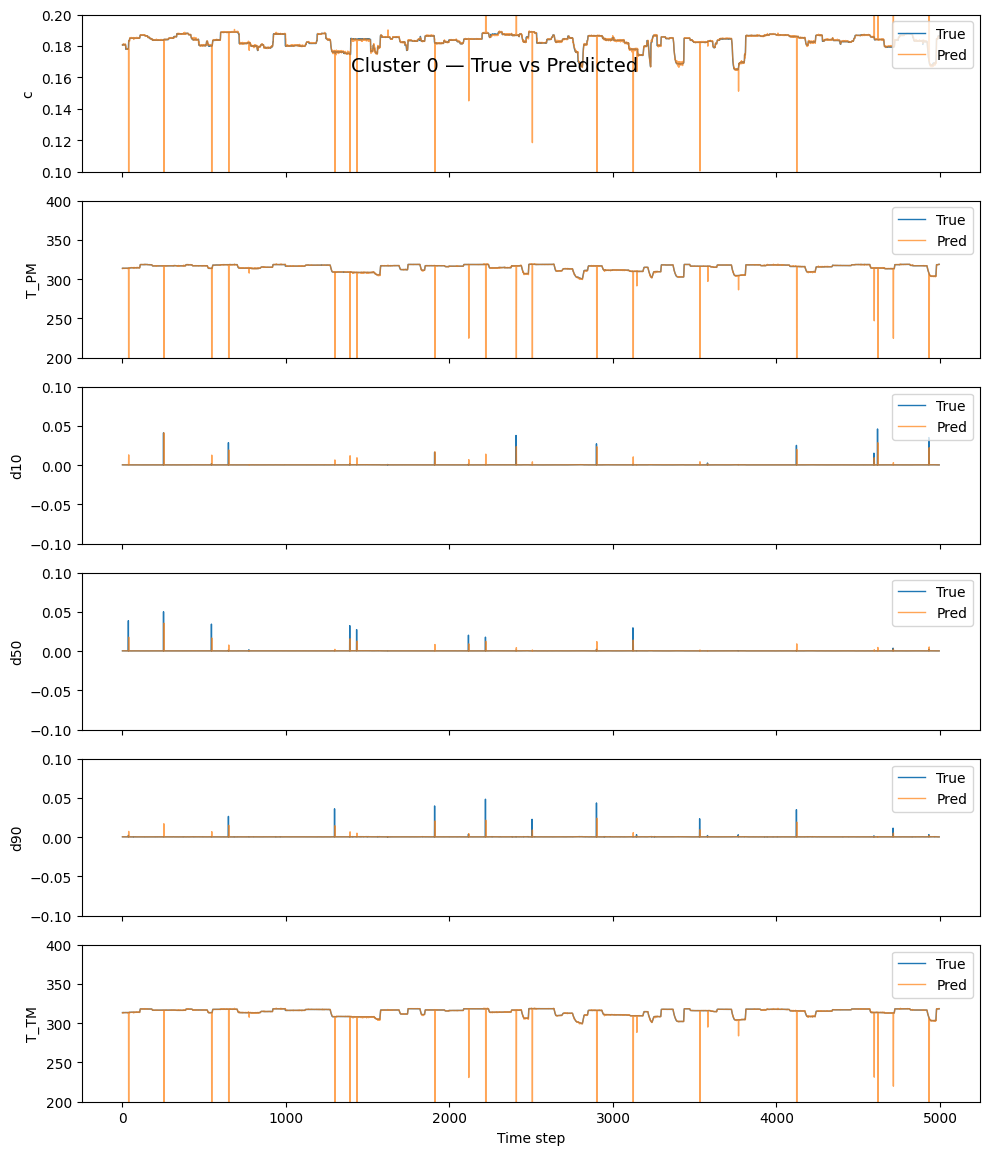

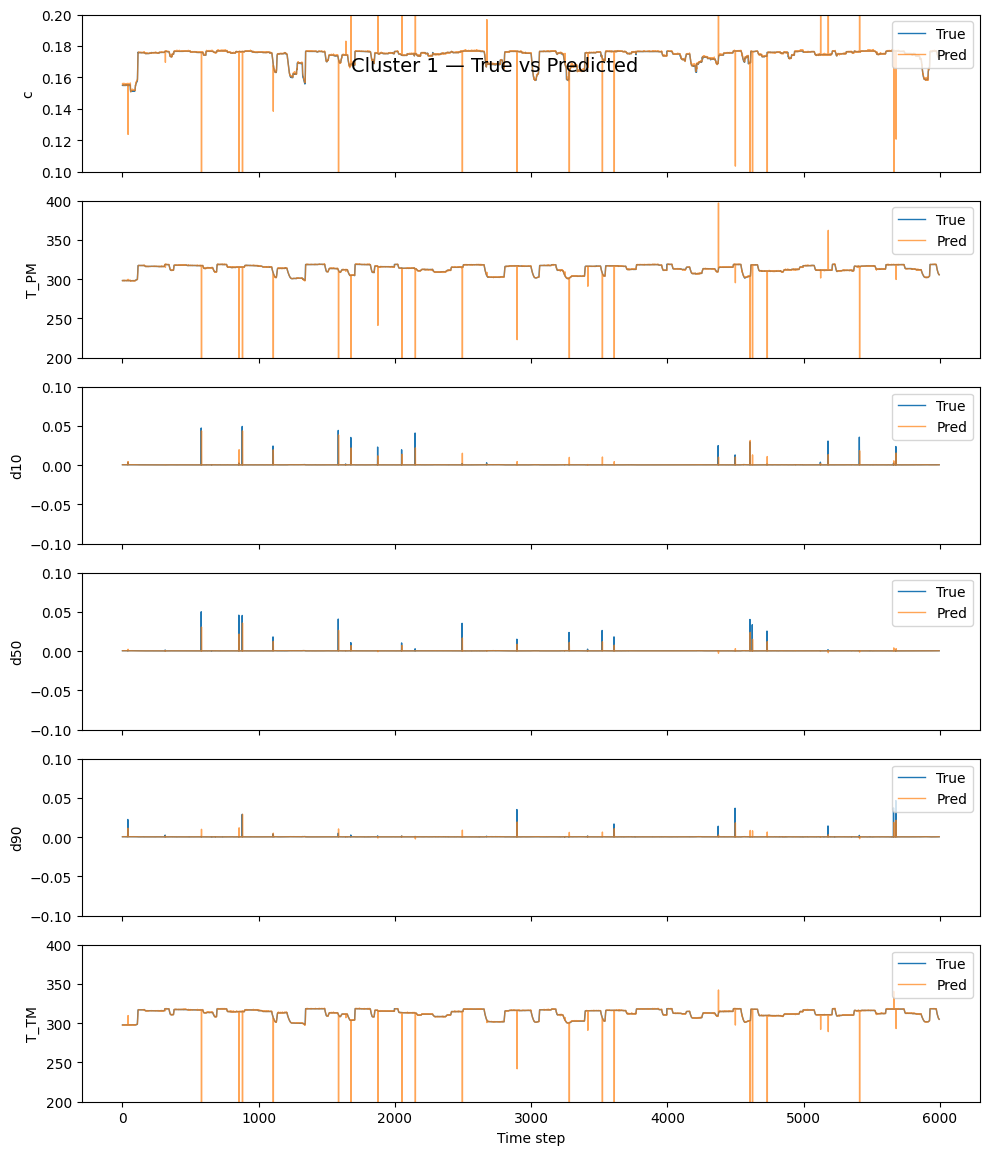

In [53]:
# ── PLOT TEST TRAJECTORIES FOR MULTIPLE CLUSTERS ───────────────────────────────
import matplotlib.pyplot as plt

for cluster_id in ("0","1"):
    # ── Load model + scalers ─────────────────────────────────────────────────
    ckpt = torch.load(
        os.path.join(DATA_DIR_OUT, f"narx_cluster_{cluster_id}.pt"),
        map_location="cpu",
        weights_only=False  # Fix for UnpicklingError in PyTorch >=2.6
    )
    xsc = StandardScaler(); xsc.mean_, xsc.scale_ = ckpt["x_mean"], ckpt["x_scale"]
    ysc = StandardScaler(); ysc.mean_, ysc.scale_ = ckpt["y_mean"], ckpt["y_scale"]

    d_in = len(xsc.mean_)
    model = NARXNetReg(d_in, len(TARGET_COLS))
    model.load_state_dict(ckpt["model"])
    model.eval()

    # ── Build full test trajectory ─────────────────────────────────────────
    test_csv  = os.path.join(DATA_DIR_OUT, f"cluster_{cluster_id}_test.csv")
    test_files = pd.read_csv(test_csv, header=None)[0].dropna().astype(str)
    frames = []
    for fn in test_files:
        df = read_txt(os.path.join(DATA_DIR_IN, fn))
        frames.append(df[TARGET_COLS + INPUT_COLS])
    full_df = pd.concat(frames, ignore_index=True)

    # ── Predict ───────────────────────────────────────────────────────────
    X_full, Y_full = build_narx(full_df)
    X_scaled       = xsc.transform(X_full)
    with torch.no_grad():
        preds_scaled = model(torch.from_numpy(X_scaled)).numpy()
    preds = ysc.inverse_transform(preds_scaled)

    # ── Plot ───────────────────────────────────────────────────────────────
    time = np.arange(len(preds))
    fig, axes = plt.subplots(len(TARGET_COLS), 1, figsize=(10, 12), sharex=True)
    fig.suptitle(f"Cluster {cluster_id} — True vs Predicted", y=0.92, fontsize=14)
    for i, state in enumerate(TARGET_COLS):
        axes[i].plot(time, Y_full[:,i], label="True", linewidth=1)
        axes[i].plot(time, preds[:,i], label="Pred", linewidth=1, alpha=0.7)
        axes[i].set_ylabel(state)
        
        if state in ( "T_PM", "T_TM"):
            axes[i].set_ylim(200, 400)
        if state in ( "c"):
            axes[i].set_ylim(0.1, 0.2)
        if state in ( "d90", "d50", "d10"):
            axes[i].set_ylim(-0.1, 0.1)
        
        axes[i].legend(loc="upper right")
    axes[-1].set_xlabel("Time step")
    plt.tight_layout()
    plt.show() 